# **Learning Bayesian Networks from Big Data with Greedy Search**

**Rocchi Niccolò, 10/01/2023**

*Università degli Studi di Milano Bicocca, Dipartimento di Informatica, Sistemistica e Comunicazione, M.Sc. Data Science*

# Introduction

## Abstract

Structure identification task has been a crucial and well studied problem of Probabilistic Graphical Models in the last decades. Not only it's concerned with learning Bayesian Networks but also their causal version, namely Causal Networks. 
Indeed it's the really first step in discovering the ground truth underlying data at hand, and the basis from which we have to start when speaking about Causal Inference.


In this work, which main reference is [1]: "*Learning Bayesian Networks from Big Data with Greedy Search: computational complexity and efficient implementation*" by M. Scutari et al., we focused on a greedy approach for Bayesian Network Learning from data. In particular it has been implemented the Hill-Climbing algorithm, a very well known trajectory-based metaheuristic when dealing with optimization in huge parameter spaces, as in the case of the space of possible DAGs with just $n > 10$ nodes. Its purpose, in fact, is to find the DAG that locally - hopefully globally - maximizes a given score function $\text{Score}(\mathcal{G}|\mathbf{D})$. Because of the variety of these functions, different implementations can be found. It's worth also to observe that this procedure only focuses on structure learning, meaning a correct couple of nodes and directed edges with no cycles, and not on parameter learning, that could follow in the study.
After having implemented the Log-Likelihood score function and Hill-Climbing, it has been found a local maximum starting from an empty initialized graph. This one was then compared with the true graph, computing the number of correct, missed, extra or reversed edges. In order to perform a simple but effective sensitivity analysis of the obtained result, the same algorithm was finally run starting from 20 different random initializations.














## Score function and its computation

Dealing with a binary - and so categorical - data set of 5000 observation and 8 variables $\{X_i\}_{i}$, the choosen score function was the *Log-Likelihood*.
Given a dataset $\mathbf{D}$ and a DAG $\mathcal{G}$,
it's defined as follow:

$$
LL(\mathcal{G}|\mathbf{D}) = \sum_{i=1}^{n}\sum_{j=1}^{q_i}\sum_{k=1}^{r_i}N_{ijk} \cdot \log \left(\frac{N_{ijk} }{N_{ij\star}}\right)
$$

where $n$ is the number of variables, $q_i$ the number of different configurations of $Pa(X_i)$, $r_i$ the number of levels of $X_i$,
$N_{ijk}$ the absolute frequency of observing $X_i$ with the $j$-th configuration and the $k$-th level, and $N_{ij\star} = \sum_{k=1}^{r_i}N_{ijk}$.
From a mathematical point of view, the term $\frac{N_{ijk}}{N_{ij\star}}$ represents the frequentist probability $P(X_i = k| Pa(X_i)=j)$.

In order to make these definition more practical, if we indicate $r_i = |\text{Dom}(X_i)|$ the cardinality of the domain of the $i$-th variable,
we could state that $q_i$ can be computed as:
$$
q_i = |\text{Dom}(X_{i+1}) \times \text{Dom}(X_{i+2})\times \cdots \times \text{Dom}(X_{i+j})| = \prod_{k=1}^j|\text{Dom}(X_{i+k})|=\prod_{k=1}^jr_{i+k}
$$
being $X_{i+1},X_{i+2}, \cdots, X_{i+j}$ the set $Pa(X_i)$. Moreover, indicating $N_i$ a $q_i \times r_i$ matrix, we can define $N_{ijk}$ as its $(j,k)$-th position representing the count of observations in $\mathbf{D}$ such that $X_i$ = $j$-th level and $Pa(X_i)$ = $k$-th configuration at the same time.

Observing that a $\log$ is present in the score definition, we constrain the entire addend to be 0 if $N_{ijk}=0$ for some $i,j,k$.

Now, from the Markov assumption about $\mathcal{G}$ and his underlying probability distribution $P$, we have that
$$
P(\mathbf{X}|\mathcal{G}, \Theta) = \prod_{i=1}^n P(X_i|\Pi_{X_i}, \Theta_{X_i})
$$
and we call each term *local distribution*. Since the Log-Likelihood score function is a sum over $n$, it holds its *decomposability* into one component for each local distribution, that is each term in the sum over $n$. In the following we will indicate this quantity as $ll(X_i|Pa(X_i))$.

The overall computation of $LL(\mathcal{G}|\mathbf{D})$ can be then summarized as follows:
1. For any $(i,j,k)\in \{1,\cdots ,n\}\times \{1,\cdots ,q_i\}\times\{1,\cdots ,r_i\}$ compute the matrix $N_{ijk}$.

2. Compute $S_{ijk} = N_i[j,k] \cdot \log \left( \frac{N_i[j,k]}{\sum_{k=1 }^{r_i}N_i[j,k]}\right)$

3. Compute the local scores as $\sum_{j=1}^{q_i}\sum_{k=1}^{r_i}S_{ijk}$ and then sum over $n$ to obtain the global score.


## Hill-Climbing and its computation

The theoretical intuition behind Hill-Climbing is straightforward. Initializing a DAG $\mathcal{G}$ (usually the empty one), at each step of the algorithm we consider any *neighbour* resulted from an arch addition, deletion or reversal - still a DAG $\mathcal{G}^*$- of the current graph, computing $LL(\mathcal{G}^*|\mathbf{D})$. If $LL(\mathcal{G}^*|\mathbf{D}) > LL(\mathcal{G}|\mathbf{D})$ (improvement move) and $LL(\mathcal{G}^*|\mathbf{D})$ is the highest among all neighbours, then $\mathcal{G}^*$ becomes the new current DAG $\mathcal{G}$. After having visited every *neighbour* of $\mathcal{G}$, either 
such a improvement was done or not. In the first case, the graph is updated and an other iteration - i.e. a valuation of a new neighborhood-  is done, while in the latter the algorithm terminates.
Actually, a few considerations are worth to mention to make the computation more feasible.

We mentioned the decomposability of the score function into local scores.
Let's now suppose we are only interested in edge modifications such as additions and deletions. Then this observation eases the computation, since the score of each neighbour in one iteration only 
differs from $\mathcal{G}$ score by one local score: the one corresponding to the node that acquired - or lost - a parent. Then, as stated in the paper, if we initially cache every local score of $\mathcal{G}$ and every local difference in scores
corresponding to each neighbour, for each iteration of Hill-Climbing we are able to choose the best neighbour by simply find the best local difference; 
clearly this changement must bring a higher global score than before.
Finally, for the next step, we only have to compute $n$ new local differences, those corresponding to the variable whose parents were changed in the previous iteration. 
Still, the edge reversal situation is similar. In this case each neighbour will differ for two local scores, since two node parent sets changed. Then the computation of the new global score 
must take into account both differences, not just the one regarding the node that achieved a new parent. If such an edge reversal was made 
in the previous iteration, then we compute $2n$ new local scores.

The last consideration is about the constraint of each neighbour to be acyclic. It can ease the computation to check the condition only if the neighbour translates in a better move.

Finally, the procedure of Hill-Climbing can be summarized as follows:

1. Initialize a graph $\mathcal{G}$ (usually the empty graph) with $n$ nodes
2. Compute and cache $ll(X_i|Pa(X_i))$ for all $i$
3. For each variable compute and cache $\Delta_{ij} = ll(X_i|Pa(X_i)) - ll(X_i|Pa^*_j(X_i))$ for all $j\neq i$, where $Pa^*_j(X_i)$ is the modification of $Pa(X_i)$ as the result of adding the $j$-th variables as a parent (if $j \notin Pa(X_i))$ or removing the $j$-th parent.
4. Set the first $\Delta_{best}$ as 0. Then, with a *for* loop, iteratively compare each $\Delta_{ij}$. If $\Delta_{ij}$ implies an edge reversal from $i \rightarrow j$ to $i \leftarrow j$, than the overall score change is $\Delta_{ij}+\Delta_{ji}$ and not only $\Delta_{ij}$. If a certain $\Delta_{i^*j^*}$ is lower than the previous one and the $(i^*,j^*)$-th edge modification translates in a DAG, than $\Delta_{best} = \Delta_{i^*j^*}$. This is done for every $(i,j)$
5. If $\Delta_{best}=0$ then no improvement move was found, so exit the algorithm returning the current $\mathcal{G}$. Otherwise, compute and cache the new $\Delta_{i^*j}$ for all $j$.
6.  If the operation was an edge reversal, also compute and cache $\Delta_{j^*i}$ for all $i$.
7. Repeat from step 4.

As entailed, the algoritm terminates when no improvement move was found. We also can control the loop with a maximum number of iterations or other checks. We'll mention them in the Conclusions.

# Implementation

### Libraries

In [ ]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz matplotlib seaborn
!pip install --upgrade scipy networkx

In [ ]:
# Libraries importation
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy
import time

from networkx.drawing.nx_agraph import graphviz_layout
from typing import List

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Get machine epsilon.
e = np.finfo(np.float64).eps

### Read Data and Graph

In [ ]:
# Read data from file.
D = pd.read_csv("https://raw.githubusercontent.com/Niccolo-Rocchi/Causal-Network-project/main/final_project_data.csv", dtype = "category")

# Build the true graph.
G = nx.DiGraph([
    ("A", "T"),
    ("S", "L"),
    ("S", "B"),
    ("B", "D"),
    ("E", "D"),
    ("T", "E"),
    ("L", "E"),
    ("E", "X")
])

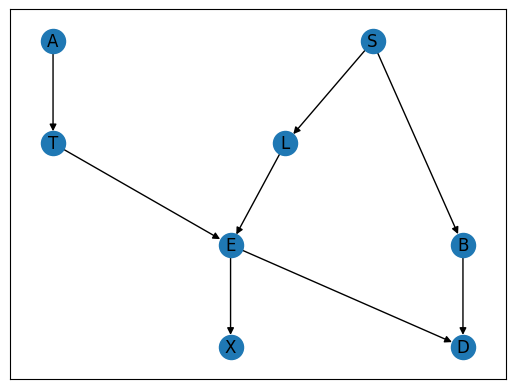

In [ ]:
nx.draw_networkx(G, pos = graphviz_layout(G, prog = "dot"), with_labels = True)

### Computing the Absolute Frequencies

In [ ]:
# Compute the absolute frequencies N(X, Pa(X) | D).
def N(X: str, Z: List[str], D: pd.DataFrame) -> np.ndarray:

  configurations = [list(iter) for iter in itertools.product(*[D[s].unique().to_list() for s in Z])]
  levels = D[X].unique().to_list()

  q_i = len(configurations)
  r_i = len(levels)

  N = np.empty((q_i, r_i))
  for j in range(q_i):
    for i in range(r_i):
      N[j, i] = (D[[X] + Z] == [levels[i]] + configurations[j]).apply(np.prod, axis = 1).sum()

  return N

In [ ]:
# Compute N(A | D).
np.testing.assert_equal(
    N("A", [], D),
    np.array([[4958,   42]])
)

In [ ]:
# Compute N(A, [L] | D).
np.testing.assert_equal(
    N("A", ["L"], D),
    np.array([
        [4632,   38],
        [ 326,    4]
    ])
)

In [ ]:
# Compute N(A, [L, T] | D).
np.testing.assert_equal(
    N("A", ["L", "T"], D),
    np.array([
        [4594,   36],
        [  38,    2],
        [ 322,    4],
        [   4,    0]
    ])
)

### Computing the Log-Likelihood

In [ ]:
# Compute log-likelihood of ll(X, Pa(X) | D).
def ll(X: str, Z: List[str], D: pd.DataFrame) -> float:
  M = N(X, Z, D)
  q_i, r_i = M.shape
  ll = 0
  for j in range(q_i):
    N_ij = M[j,:].sum()
    for i in range(r_i):
      N_ijk = M[j, i]
      if N_ijk != 0:
        ll += N_ijk * np.log(N_ijk / N_ij)
  return ll

In [ ]:
# Compute ll(A | D).
np.testing.assert_approx_equal(
    ll("A", [], D),
    -242.5631
)

In [ ]:
# Compute ll(A, [L] | D).
np.testing.assert_approx_equal(
    ll("A", ["L"], D),
    -242.3023
)

In [ ]:
# Compute ll(A, [L, T] | D).
np.testing.assert_approx_equal(
    ll("A", ["L", "T"], D),
    -240.2226
)

In [ ]:
# Compute log-likelihood of LL(G | D).
def LL(G: nx.DiGraph, D: pd.DataFrame) -> float:
  LL = 0
  for node in G.nodes:
    LL += ll(node, list(G.predecessors(node)), D)
  return LL

In [ ]:
# Compute LL(G | D).
np.testing.assert_approx_equal(
    LL(G, D),
    -11033.0871
)

### Implementing Hill-Climbing

In [ ]:
# Compute Score(node | Pa*(node)) for any modification Pa*(node) of Pa(node)
def new_local_scores(node: str, G:nx.DiGraph, D: pd.DataFrame) -> dict:
  
  nodes = set(D.columns)
  Parents = set(G.predecessors(node))
  Not_Parents = nodes - Parents - set(node)

  return {
      **{parent:ll(node, list(Parents - set(parent)), D) for parent in Parents},                      # removing a parent
      **{not_parent:ll(node, list(Parents | set(not_parent)), D) for not_parent in Not_Parents}       # adding a parent
      }

In [ ]:
# Hill-Climbing

'''
INPUT: 
  - D: dataframe from which we want to extract a DAG G
  - Score_local: Score(X | Pa(X)) for every X in G. Its sum is the global score
  - maxit: maximum number of allowed iteration
  - init: inizialized DAG. It can be 'empty' or 'random'

OUTPUT:
  - G: the DAG maximizing the global score
  - operations: history of edge operations
  - values: history of global scores
  - times: history of computing times
'''
def HC(D: pd.DataFrame, Score_local = ll, maxit: int = 100, init:str = 'empty') -> tuple:

  # Initialize the DAG G
  nodes = set(D.columns)
  n = len(nodes)
  if init == 'empty':
    G = nx.relabel_nodes(nx.empty_graph(n, nx.DiGraph), dict(zip(list(range(n)), nodes)))
  if init == 'random':
    # p = 0.1 means a pretty sparse initialization
    G = nx.relabel_nodes(nx.fast_gnp_random_graph(n, p = 0.1, directed = True), dict(zip(list(range(n)), nodes)))

  # Cache G local scores in B_G
  B_G = {node : ll(node, list(G.predecessors(node)), D) for node in nodes}

  # Cache G global score in S_G
  S_G = sum(B_G.values())

  # Cache Score(node | Pa*(node)) for any modifications of Pa(node)
  Mod_scores = dict()
  for node in nodes:
    Mod_scores[node] = new_local_scores(node, G, D)

  # Initialize 'iter' as current iteration and other outputs
  iter = 1
  operations = []
  values = []
  times = []

  # Main loop
  while iter <= maxit:
    start = time.time()
    delta_old = 0
    
    # Iterating on every possible arc addition, removal or reversal. 
    for i in nodes:
      for j in Mod_scores[i]:

        # 'delta_new' is: Score(X|Pa(X)) - Score(X|Pa*(X)). We want it to be:
        #     1) < 0 (correspoding to a neighbour with higher global score than G), and
        #     2) the minimum for every i,j
        delta_new = B_G[i] - Mod_scores[i][j]

        # In case of edge reversal, 'delta_rev' takes into account also the change in Score(j|Pa(j))
        delta_rev = 0
        if i in G.predecessors(j): delta_rev =  Mod_scores[j][i] - B_G[j]

        # Condition corresponding to a new improvement move
        if delta_new < delta_old + delta_rev:

          # Found a neighbour with better score, we verify it is a DAG
          H = G.copy()

          # Case of edge removal
          if j in H.predecessors(i): 
            H.remove_edge(j, i)
            operation = 'removal'

          # Case of edge reversal
          elif j in H.successors(i):
            H.remove_edge(i, j)
            H.add_edge(j, i)
            operation = 'reversion'

          # 3) Case of edge addition
          else: 
            H.add_edge(j, i)
            operation = 'addition'

          if nx.is_directed_acyclic_graph(H):

            # Update the new minimum for delta
            delta_old = delta_new

            # Cache actual best neighbour
            H_best = H
            i_final = i
            j_final = j
            last_op = operation

    # If no improvement on global score was done, then stop the iteration
    if delta_old == 0: 
      if iter == 1: values = [S_G]
      break 

    # Update G
    G = H_best
    
    # Update local scores
    i, j = i_final, j_final
    B_G[i] = Mod_scores[i][j]
    Mod_scores[i] = new_local_scores(i, G, D)
    if last_op == 'reversion':
      B_G[j] = ll(j, list(G.predecessors(j)), D)
      Mod_scores[j] = new_local_scores(j, H, D)

    # Update global score
    S_G = sum(B_G.values())

    # Update output parameters
    end = time.time()
    times = times + [end - start]
    operations = operations + [last_op]
    values = values + [round(S_G, 4)]
    
    iter += 1

  return (G, operations, values, times)

In [ ]:
# Run Hill-Climbing
(H, operations, values, times) = HC(D)

In [ ]:
# See history
Results = pd.DataFrame({'operations':operations, 'values':values, 'times':times})
Results

,operations,values,times
0,addition,-14002.2498,9.693599
1,addition,-12913.1548,9.576259
2,addition,-11980.7654,9.538055
3,addition,-11529.4369,9.772676
4,addition,-11299.2074,16.740598
5,addition,-11159.8529,17.079085
6,addition,-11034.8972,9.484076
7,addition,-11031.7822,29.101212
8,addition,-11028.5739,53.621154
9,addition,-11025.9108,16.942921


Text(0, 0.5, 'Log-Likelihood')

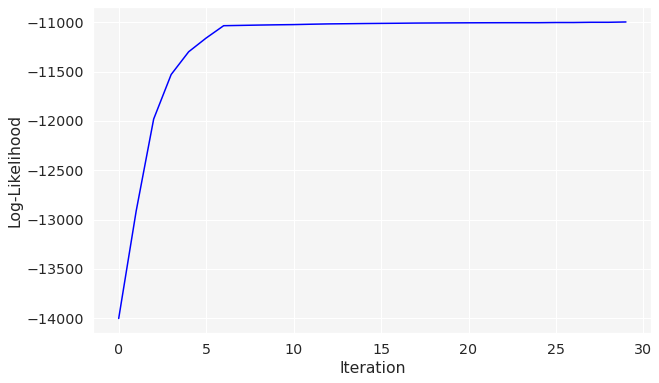

In [ ]:
# Plot Log-Likelihood history
plt.plot(Results['values'], 'blue')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')

Text(0, 0.5, 'Execution time')

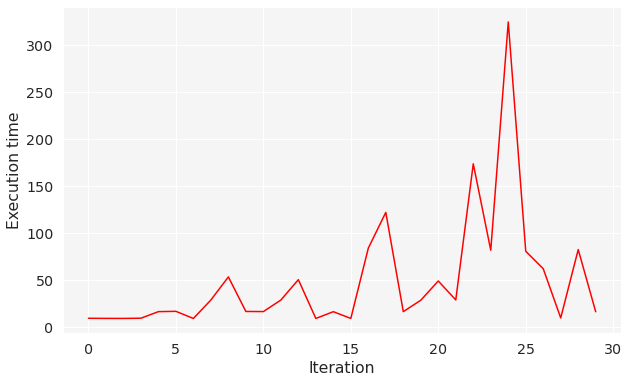

In [ ]:
# Plot execution time history
plt.plot(Results['times'], 'red')
plt.xlabel('Iteration')
plt.ylabel('Execution time')

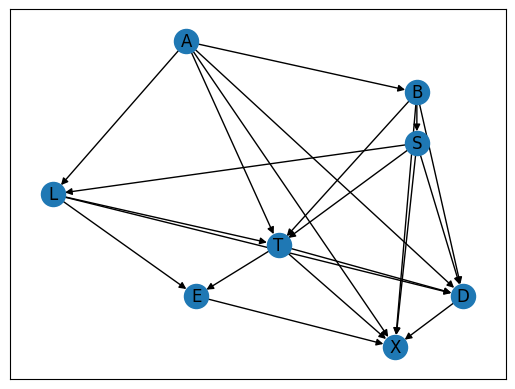

In [ ]:
# Plot Hill-Climbing resulting graph
nx.draw_networkx(H, pos = graphviz_layout(H, prog = "dot"), with_labels = True)

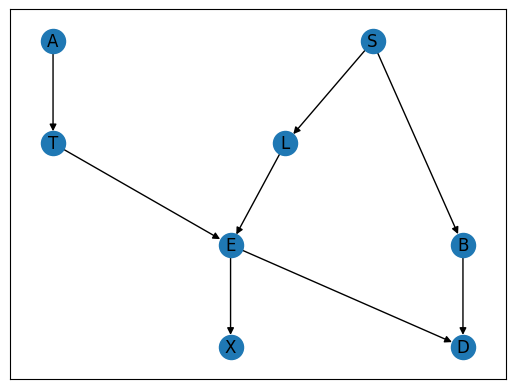

In [ ]:
# Plot the true graph.
G = nx.DiGraph([("A", "T"),("S", "L"),("S", "B"),("B", "D"),("E", "D"),("T", "E"),("L", "E"),("E", "X")])
nx.draw_networkx(G, pos = graphviz_layout(G, prog = "dot"), with_labels = True)

# Testing Hill-Climbing

In [ ]:
# Compute graphs differences between edges
def graphs_score(G: nx.DiGraph, H: nx.DiGraph):

  # Compute adjacence matrices
  nodelist = G.nodes()
  Ad_G = nx.adjacency_matrix(G, nodelist).toarray()
  Ad_H = nx.adjacency_matrix(H, nodelist).toarray()

  # Number of same edges
  same = np.sum(Ad_G * Ad_H)

  # Number of reversed edges
  mask = np.transpose(Ad_G) * Ad_H
  reversed = np.sum(mask)
  mask = (1 + mask)%2

  # Number of extra or missing edges
  A = Ad_G - Ad_H*mask
  freq = np.unique(A, return_counts = True)
  freq = {f"{freq[0][k]}" : freq[1][k] for k in range(len(freq[0]))}
  extra = freq.get('-1', 0)
  missing = freq.get('1', 0) - reversed
  
  return (same, extra, missing, reversed)

In [ ]:
# Compute the score between G and H 
same, extra, missing, reversed = graphs_score(G, H)
print(f"same edges: {same}\nextra edges: {extra}\nmissing edges: {missing}\nreversed edges: {reversed}")

same edges: 6
extra edges: 14
missing edges: 1
reversed edges: 1


In [ ]:
# Test HC with different random initializations
iters = 20
Accuracy_matrix = np.empty((iters, 5))

for init in range(iters):
  H, _, values, _ = HC(D, init='random')
  score_list = list(graphs_score(G, H))
  Accuracy_matrix[init, :] = np.array(score_list + [values[-1]])

Accuracy = pd.DataFrame(Accuracy_matrix, columns = ['same', 'extra', 'missing', 'reversed', 'LL'])

In [ ]:
Accuracy.describe()

,same,extra,missing,reversed,LL
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.400000,15.700000,1.450000,3.150000,-11262.276108
std,2.137387,4.079474,2.459675,2.158825,1084.448921
min,0.000000,6.000000,0.000000,0.000000,-14156.854623
25%,2.000000,15.750000,0.000000,1.000000,-11003.080225
50%,3.500000,17.000000,1.000000,4.000000,-10983.370050
75%,5.000000,18.000000,1.000000,4.250000,-10868.751550
max,7.000000,19.000000,8.000000,8.000000,-10173.958200


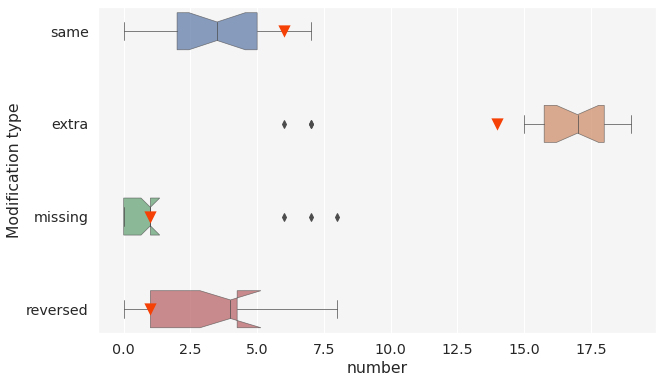

In [ ]:
# Plot final results
results = pd.melt(Accuracy.drop('LL', axis=1), var_name='Modification type', value_name='number')
final_DAG_score = pd.DataFrame({'same': [same], 'extra': [extra],'missing': [missing],'reversed': [reversed]})
final_DAG_score = pd.melt(final_DAG_score, var_name='Modification type', value_name='number')
sns.set(rc={'axes.facecolor':'whitesmoke','figure.facecolor':'white','figure.figsize':(10,6)},font_scale=1.3)  

# Plot results of Hill-Climbing (with random initializations) through boxplots with 95% confidence interval for the medians
sns.boxplot(
    y = 'Modification type',
    x = 'number',
    data = results,
    notch = True, boxprops=dict(alpha=0.7), linewidth = 0.7, width = 0.4, zorder = 1
)

# Plot results of Hill-Climbing (with empty graph initialization)
sns.scatterplot(
    y = 'Modification type',
    x = 'number',
    data = final_DAG_score, s = 150, color = '#f54105', marker = 'v', linewidth = 0, zorder = 2
)


# Conclusions and further improvements

Looking at the predicted graph from empty initialization, but in general by several random initializations, the really first evidence is the high number of extra edges. Furthermore, referring to the Log-Likelihood history plot, we see how with just the first iterations we can achieve almost the highest score but persisting in making other small improvements in score we end up in a low edges accuracy. 
These facts are suggesting either to choose an other stopping criteria in Hill-Climbing - such as lower number of maximum iterations or a control on the relative score improvements - or to constrain each node to have a maximum number of parents, as suggested in the reference paper. By the way, supposing not to know the true graph, this number - or the maximum number of iterations - is an hyperparameter that can't be optimally chosen without background knowledge. However, the experience recommends to look for a sparse graph. 
On the other hand, it's worth to highlight how an empty initialization translates, in general, in a higher number of well predicted edges and lower number of extra edges, whereas the number of missing or reversed edges follows the general distribution. 
These facts are also consistent with the fact that almost the entire edges operations history consists in edge additions. Only in the last iterations the algorithm performs edge removal or reversal.

An other possible improvement is to implement the hole algorithm described in [1], thus adding a Tabu Search and a Random Restart blocks after Hill-Climbing. This procedure may give more consistent results.


# References

1. "*Learning Bayesian Networks from Big Data with Greedy Search: computational complexity and efficient implementation*", M. Scutari, C. Vitolo, A. Tucker, 2019. [https://link.springer.com/article/10.1007/s11222-019-09857-1](https://)